In [1]:
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm
import os

In [2]:
df = pd.read_csv('/content/drive/MyDrive/esc50.csv')

In [4]:
train = df[df['fold']!=5]
valid = df[df['fold']==5]

In [5]:
wav, sr = librosa.load('/content/drive/MyDrive/audio/1-100032-A-0.wav', sr=None)
print(f'Sampling rate of the audio is {sr} and length of the audio is {len(wav)/sr} seconds')

Sampling rate of the audio is 44100 and length of the audio is 5.0 seconds


In [6]:
def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled

In [7]:
def get_melspectrogram_db(file_path, sr=44100, n_fft=16384, hop_length=308, n_mels=256, fmin=20, fmax=17000, top_db=80, win_length=3969):
  wav,sr = librosa.load(file_path,sr=sr)
  if wav.shape[0]<5*sr:
    wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
  else:
    wav=wav[:5*sr]
  spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
              hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax, win_length=win_length)
  spec_db=librosa.power_to_db(spec,top_db=top_db)
  return spec_db

In [8]:
class Network(Dataset):
  def __init__(self, base, df, in_col, out_col):
    self.df = df
    self.data = []
    self.labels = []
    self.c2i={}
    self.i2c={}
    self.categories = sorted(df[out_col].unique())
    for i, category in enumerate(self.categories):
      self.c2i[category]=i
      self.i2c[i]=category
    for ind in tqdm(range(len(df))):
      row = df.iloc[ind]
      file_path = os.path.join(base,row[in_col])
      self.data.append(spec_to_image(get_melspectrogram_db(file_path))[np.newaxis,...])
      self.labels.append(self.c2i[row['category']])
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

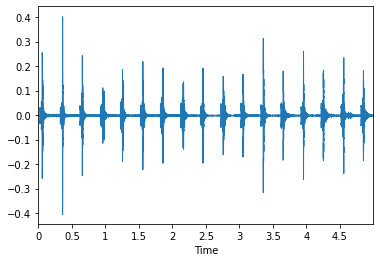

In [9]:
filename = valid[valid['category']=='clock_tick'].iloc[0]['filename']
wav, sr = librosa.load('/content/drive/MyDrive/audio/'+filename, sr=None)
librosa.display.waveplot(wav, sr);

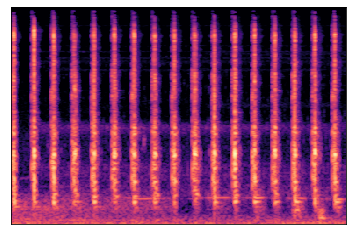

In [10]:
librosa.display.specshow(spec_to_image(get_melspectrogram_db('/content/drive/MyDrive/audio/'+filename, sr)));

In [11]:
train_data = Network('/content/drive/MyDrive/audio/', train, 'filename', 'category')

<ipython-input-8-5750bf09c2cd>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ind in tqdm(range(len(df))):


  0%|          | 0/1600 [00:00<?, ?it/s]

In [12]:
valid_data = Network('/content/drive/MyDrive/audio/', valid, 'filename', 'category')

<ipython-input-8-5750bf09c2cd>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ind in tqdm(range(len(df))):


  0%|          | 0/400 [00:00<?, ?it/s]

In [13]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=64, shuffle=True)

In [14]:
if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device=torch.device('cpu')

In [ ]:
from torchvision.models import resnet18
cnn = resnet18(pretrained=True)
cnn.fc = nn.Linear(512,50)
cnn.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
cnn = cnn.to(device)

In [17]:
from torch import nn
from torchsummary import summary

In [ ]:
summary(cnn, (1, 64, 44))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 22]           3,136
       BatchNorm2d-2           [-1, 64, 32, 22]             128
              ReLU-3           [-1, 64, 32, 22]               0
         MaxPool2d-4           [-1, 64, 16, 11]               0
            Conv2d-5           [-1, 64, 16, 11]          36,864
       BatchNorm2d-6           [-1, 64, 16, 11]             128
              ReLU-7           [-1, 64, 16, 11]               0
            Conv2d-8           [-1, 64, 16, 11]          36,864
       BatchNorm2d-9           [-1, 64, 16, 11]             128
             ReLU-10           [-1, 64, 16, 11]               0
       BasicBlock-11           [-1, 64, 16, 11]               0
           Conv2d-12           [-1, 64, 16, 11]          36,864
      BatchNorm2d-13           [-1, 64, 16, 11]             128
             ReLU-14           [-1, 64,

In [ ]:
def setlr(optimizer, lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr
  return optimizer

In [ ]:
def train(cnn, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
  for epoch in tqdm(range(1,epochs+1)):
    cnn.train()
    batch_losses=[]
    if change_lr:
      optimizer = change_lr(optimizer, epoch)
    for i, data in enumerate(train_loader):
      x, y = data
      optimizer.zero_grad()
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = cnn(x)
      loss = loss_fn(y_hat, y)
      loss.backward()
      batch_losses.append(loss.item())
      optimizer.step()
    train_losses.append(batch_losses)
    print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
    cnn.eval()
    batch_losses=[]
    trace_y = []
    trace_yhat = []
    for i, data in enumerate(valid_loader):
      x, y = data
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = cnn(x)
      loss = loss_fn(y_hat, y)
      trace_y.append(y.cpu().detach().numpy())
      trace_yhat.append(y_hat.cpu().detach().numpy())      
      batch_losses.append(loss.item())
    valid_losses.append(batch_losses)
    trace_y = np.concatenate(trace_y)
    trace_yhat = np.concatenate(trace_yhat)
    accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
    print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')

In [ ]:
learning_rate = 2e-4
optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)
epochs = 80
loss_fn = nn.CrossEntropyLoss()
cnn_train_losses=[]
cnn_valid_losses=[]
def lr_decay(optimizer, epoch):
  if epoch%10==0:
    new_lr = learning_rate / (10**(epoch//10))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer
train(cnn, loss_fn, train_loader, valid_loader, epochs, optimizer, cnn_train_losses, cnn_valid_losses, lr_decay)

<ipython-input-20-c98c6ed40a40>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(1,epochs+1)):


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 2.7716290092468263
Epoch - 1 Valid-Loss : 2.0555834429604665 Valid-Accuracy : 0.485
Epoch - 2 Train-Loss : 1.3107648038864135
Epoch - 2 Valid-Loss : 1.410842674119132 Valid-Accuracy : 0.63
Epoch - 3 Train-Loss : 0.7491533017158508
Epoch - 3 Valid-Loss : 1.2480051517486572 Valid-Accuracy : 0.69
Epoch - 4 Train-Loss : 0.431603387594223
Epoch - 4 Valid-Loss : 1.0400228670665197 Valid-Accuracy : 0.74
Epoch - 5 Train-Loss : 0.24175708293914794
Epoch - 5 Valid-Loss : 1.0343584247997828 Valid-Accuracy : 0.7475
Epoch - 6 Train-Loss : 0.14286508589982985
Epoch - 6 Valid-Loss : 0.9184334789003644 Valid-Accuracy : 0.7725
Epoch - 7 Train-Loss : 0.08369985669851303
Epoch - 7 Valid-Loss : 0.8777267251695905 Valid-Accuracy : 0.765
Epoch - 8 Train-Loss : 0.06369202613830566
Epoch - 8 Valid-Loss : 0.8300492252622332 Valid-Accuracy : 0.7725
Epoch - 9 Train-Loss : 0.055255150943994524
Epoch - 9 Valid-Loss : 0.8298800076757159 Valid-Accuracy : 0.775
Changed learning rate to 2e-05
Ep

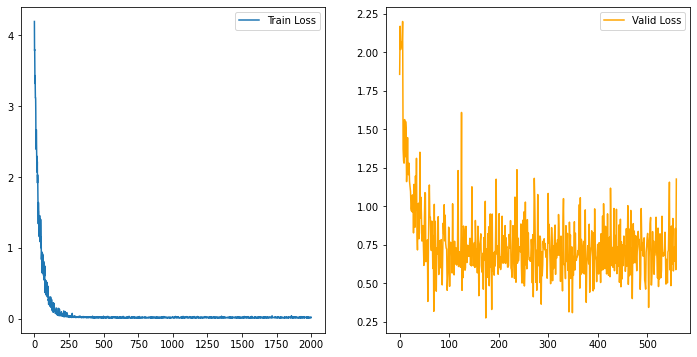

In [ ]:
tl = np.asarray(cnn_train_losses).ravel()
vl = np.asarray(cnn_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])

In [ ]:
# Best result - 0.8025

In [ ]:
with open('esc50resnet18.pth','wb') as f:
  torch.save(cnn, f)

In [ ]:
import pickle
with open('indtocat.pkl','wb') as f:
  pickle.dump(train_data.i2c, f)

In [ ]:
import IPython
with open('indtocat.pkl','rb') as f:
  indtocat = pickle.load(f)
filename='/content/pipi.wav'
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=cnn.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
print(indtocat[ind])
IPython.display.display(IPython.display.Audio(filename=filename))

In [15]:
from torchvision.models import resnet50
resnet_model = resnet50(pretrained=True)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet_model.fc = nn.Linear(in_features=2048, out_features=50, bias=True)
resnet_model = resnet_model.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [18]:
summary(resnet_model, (1, 64, 44))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 22]           3,136
       BatchNorm2d-2           [-1, 64, 32, 22]             128
              ReLU-3           [-1, 64, 32, 22]               0
         MaxPool2d-4           [-1, 64, 16, 11]               0
            Conv2d-5           [-1, 64, 16, 11]           4,096
       BatchNorm2d-6           [-1, 64, 16, 11]             128
              ReLU-7           [-1, 64, 16, 11]               0
            Conv2d-8           [-1, 64, 16, 11]          36,864
       BatchNorm2d-9           [-1, 64, 16, 11]             128
             ReLU-10           [-1, 64, 16, 11]               0
           Conv2d-11          [-1, 256, 16, 11]          16,384
      BatchNorm2d-12          [-1, 256, 16, 11]             512
           Conv2d-13          [-1, 256, 16, 11]          16,384
      BatchNorm2d-14          [-1, 256,

In [19]:
def setlr(optimizer, lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr
  return optimizer

In [20]:
def train(resnet_model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
  for epoch in tqdm(range(1,epochs+1)):
    resnet_model.train()
    batch_losses=[]
    if change_lr:
      optimizer = change_lr(optimizer, epoch)
    for i, data in enumerate(train_loader):
      x, y = data
      optimizer.zero_grad()
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = resnet_model(x)
      loss = loss_fn(y_hat, y)
      loss.backward()
      batch_losses.append(loss.item())
      optimizer.step()
    train_losses.append(batch_losses)
    print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
    resnet_model.eval()
    batch_losses=[]
    trace_y = []
    trace_yhat = []
    for i, data in enumerate(valid_loader):
      x, y = data
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = resnet_model(x)
      loss = loss_fn(y_hat, y)
      trace_y.append(y.cpu().detach().numpy())
      trace_yhat.append(y_hat.cpu().detach().numpy())      
      batch_losses.append(loss.item())
    valid_losses.append(batch_losses)
    trace_y = np.concatenate(trace_y)
    trace_yhat = np.concatenate(trace_yhat)
    accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
    print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')

In [ ]:
learning_rate = 2e-4
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate)
epochs = 80
loss_fn = nn.CrossEntropyLoss()
resnet_model_train_losses=[]
resnet_model_valid_losses=[]
def lr_decay(optimizer, epoch):
  if epoch%10==0:
    new_lr = learning_rate / (10**(epoch//10))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer
train(resnet_model, loss_fn, train_loader, valid_loader, epochs, optimizer, resnet_model_train_losses, resnet_model_valid_losses, lr_decay)

<ipython-input-20-b517820459cf>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(1,epochs+1)):


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 2.8745576763153076


In [ ]:
tl = np.asarray(cnn_train_losses).ravel()
vl = np.asarray(cnn_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])